In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def exp_plat(ym, k, x):
    return ym * (1 - np.exp(-k * x))

EIR = np.linspace(1, 100, dtype=np.float32)
k = 7 * 1e-2
ym = .8
prev = exp_plat(ym, k, EIR)

In [3]:
sample_size = 20
EIR_sample = np.random.randint(1,100,sample_size).astype(np.float32)

In [4]:
sigma = 0.1
def bounded(x, l, u):
    return np.minimum(np.maximum(x, l), u)

prev_sample = bounded(exp_plat(ym, k, EIR_sample) + np.random.normal(size=len(EIR_sample), scale=sigma), 0, 1).astype(np.float32)
pop_sample = np.maximum(np.random.normal(size=len(EIR_sample), loc=10000, scale=1000), 0.).astype(np.float32)

Text(0, 0.5, 'prev')

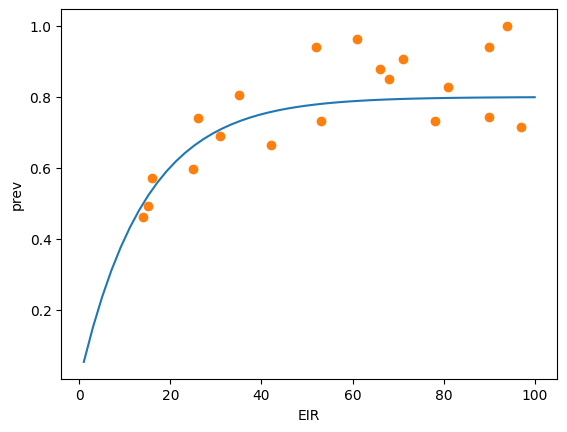

In [5]:
plt.plot(EIR, prev)
plt.plot(EIR_sample, prev_sample, 'o')
plt.xlabel('EIR')
plt.ylabel('prev')

In [9]:
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.models import load_model
import tensorflow as tf

2022-10-31 10:31:14.616647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 10:31:14.784580: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
import matplotlib.pyplot as plt

In [11]:
model = load_model('./models/eq/')

2022-10-31 10:31:17.357724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 10:31:18.273985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38406 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:27:00.0, compute capability: 8.0
2022-10-31 10:31:18.275807: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38406 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:28:00.0, compute capability: 8.0


In [12]:
bounds = pd.read_csv('./outputs/eq/bounds.csv',dtype={'name': str, 'min': np.float32, 'max': np.float32})

In [111]:
clipper = tfp.bijectors.SoftClip(bounds['min'], bounds['max'], hinge_softness=1e-10)
pop_sample_tf = tf.constant(pop_sample)

@tf.function
def model_prev(q0, s2, rU, cD, g_inf, cU, kb, ub, uc, ud, kc, b0, b1, IB0, IC0, tau, phi0, phi1, mu, f, fd0, ad0, gd, eir):
    X_ = tf.stack([
        tf.fill(q0.shape, 0.0001304631), # default age
        q0,
        s2,
        rU,
        cD,
        g_inf,
        cU,
        kb,
        ub,
        uc,
        ud,
        kc,
        b0,
        b1,
        IB0,
        IC0,
        tau,
        phi0,
        phi1,
        mu,
        f,
        fd0,
        ad0,
        gd
    ], axis=len(q0.shape))
    if len(X_.shape) == 1:
        X_ = tf.expand_dims(X_, axis=0)
        eir = tf.expand_dims(eir, axis=0)
    batch_size = X_.shape[0]
    sites = eir.shape[1]
    X_ = tf.repeat(X_, sites, axis=0)
    eir_rep = tf.reshape(eir, (batch_size * sites, 1))
    X = tf.concat([eir_rep, X_], axis=1)
    prev_pred = model(clipper(X))
    return tf.reshape(prev_pred, (batch_size, sites))

@tf.function
def prob_prev(q0, s2, rU, cD, g_inf, cU, kb, ub, uc, ud, kc, b0, b1, IB0, IC0, tau, phi0, phi1, mu, f, fd0, ad0, gd, eir):
    prev_pred = model_prev(q0, s2, rU, cD, g_inf, cU, kb, ub, uc, ud, kc, b0, b1, IB0, IC0, tau, phi0, phi1, mu, f, fd0, ad0, gd, eir)
    return tfd.Independent(
        tfd.Binomial(total_count=pop_sample_tf[tf.newaxis, :], probs=prev_pred),
        reinterpreted_batch_ndims=1
    )

In [115]:
from collections import OrderedDict
EIR_sigma = 1
EIR_guesses = bounded(EIR_sample + np.random.normal(size=len(EIR_sample), scale=EIR_sigma).astype(np.float32), 20., 40.)

joint_dist = tfp.distributions.JointDistributionNamed(
    OrderedDict(
        Q0 = tfd.Beta(1., 1.),
        s2 = tfd.Uniform(1., 3.),
        rU = tfd.Uniform(1/1000, 1/30),
        cD = tfd.Beta(1., 1.),
        g_inf = tfd.LogNormal(0., 1.),
        cU = tfd.Beta(1., 1.),
        kb = tfd.Gamma(4., 2.),
        ub = tfd.LogNormal(0., 1.),
        uc = tfd.LogNormal(0., 1.),
        ud = tfd.LogNormal(0., 1.),
        kc =  tfd.Gamma(4., 2.),
        b0 = tfd.Beta(1., 1.),
        b1 = tfd.Beta(1., 1.),
        IB0 = tfd.Gamma(5., .1),
        IC0 = tfd.Gamma(5., .1),
        tau = tfd.LogNormal(0., 1.),
        phi0 = tfd.Beta(1., 1.),
        phi1 = tfd.Beta(1., 1.),
        mu = tfd.Beta(1., 1.),
        f = tfd.Beta(1., 1.),
        fd0 = tfd.Beta(1., 1.),
        ad0 = tfd.Uniform(20 * 365, 40 * 365),
        gd = tfd.LogNormal(0., 1.),
        eir = tfd.Independent(tfd.TruncatedNormal(loc=EIR_guesses, scale=np.full(sample_size, EIR_sigma, dtype=np.float32), low=0, high=100), reinterpreted_batch_ndims=1),
        prev = lambda Q0, s2, rU, cD, g_inf, cU, kb, ub, uc, ud, kc, b0, b1, IB0, IC0, tau, phi0, phi1, mu, f, fd0, ad0, gd, eir : prob_prev(Q0, s2, rU, cD, g_inf, cU, kb, ub, uc, ud, kc, b0, b1, IB0, IC0, tau, phi0, phi1, mu, f, fd0, ad0, gd, eir)
    )
)

In [15]:
default_params = pd.read_csv('default_params.csv')

In [116]:
prior = joint_dist.sample(1000)

<Figure size 640x480 with 0 Axes>

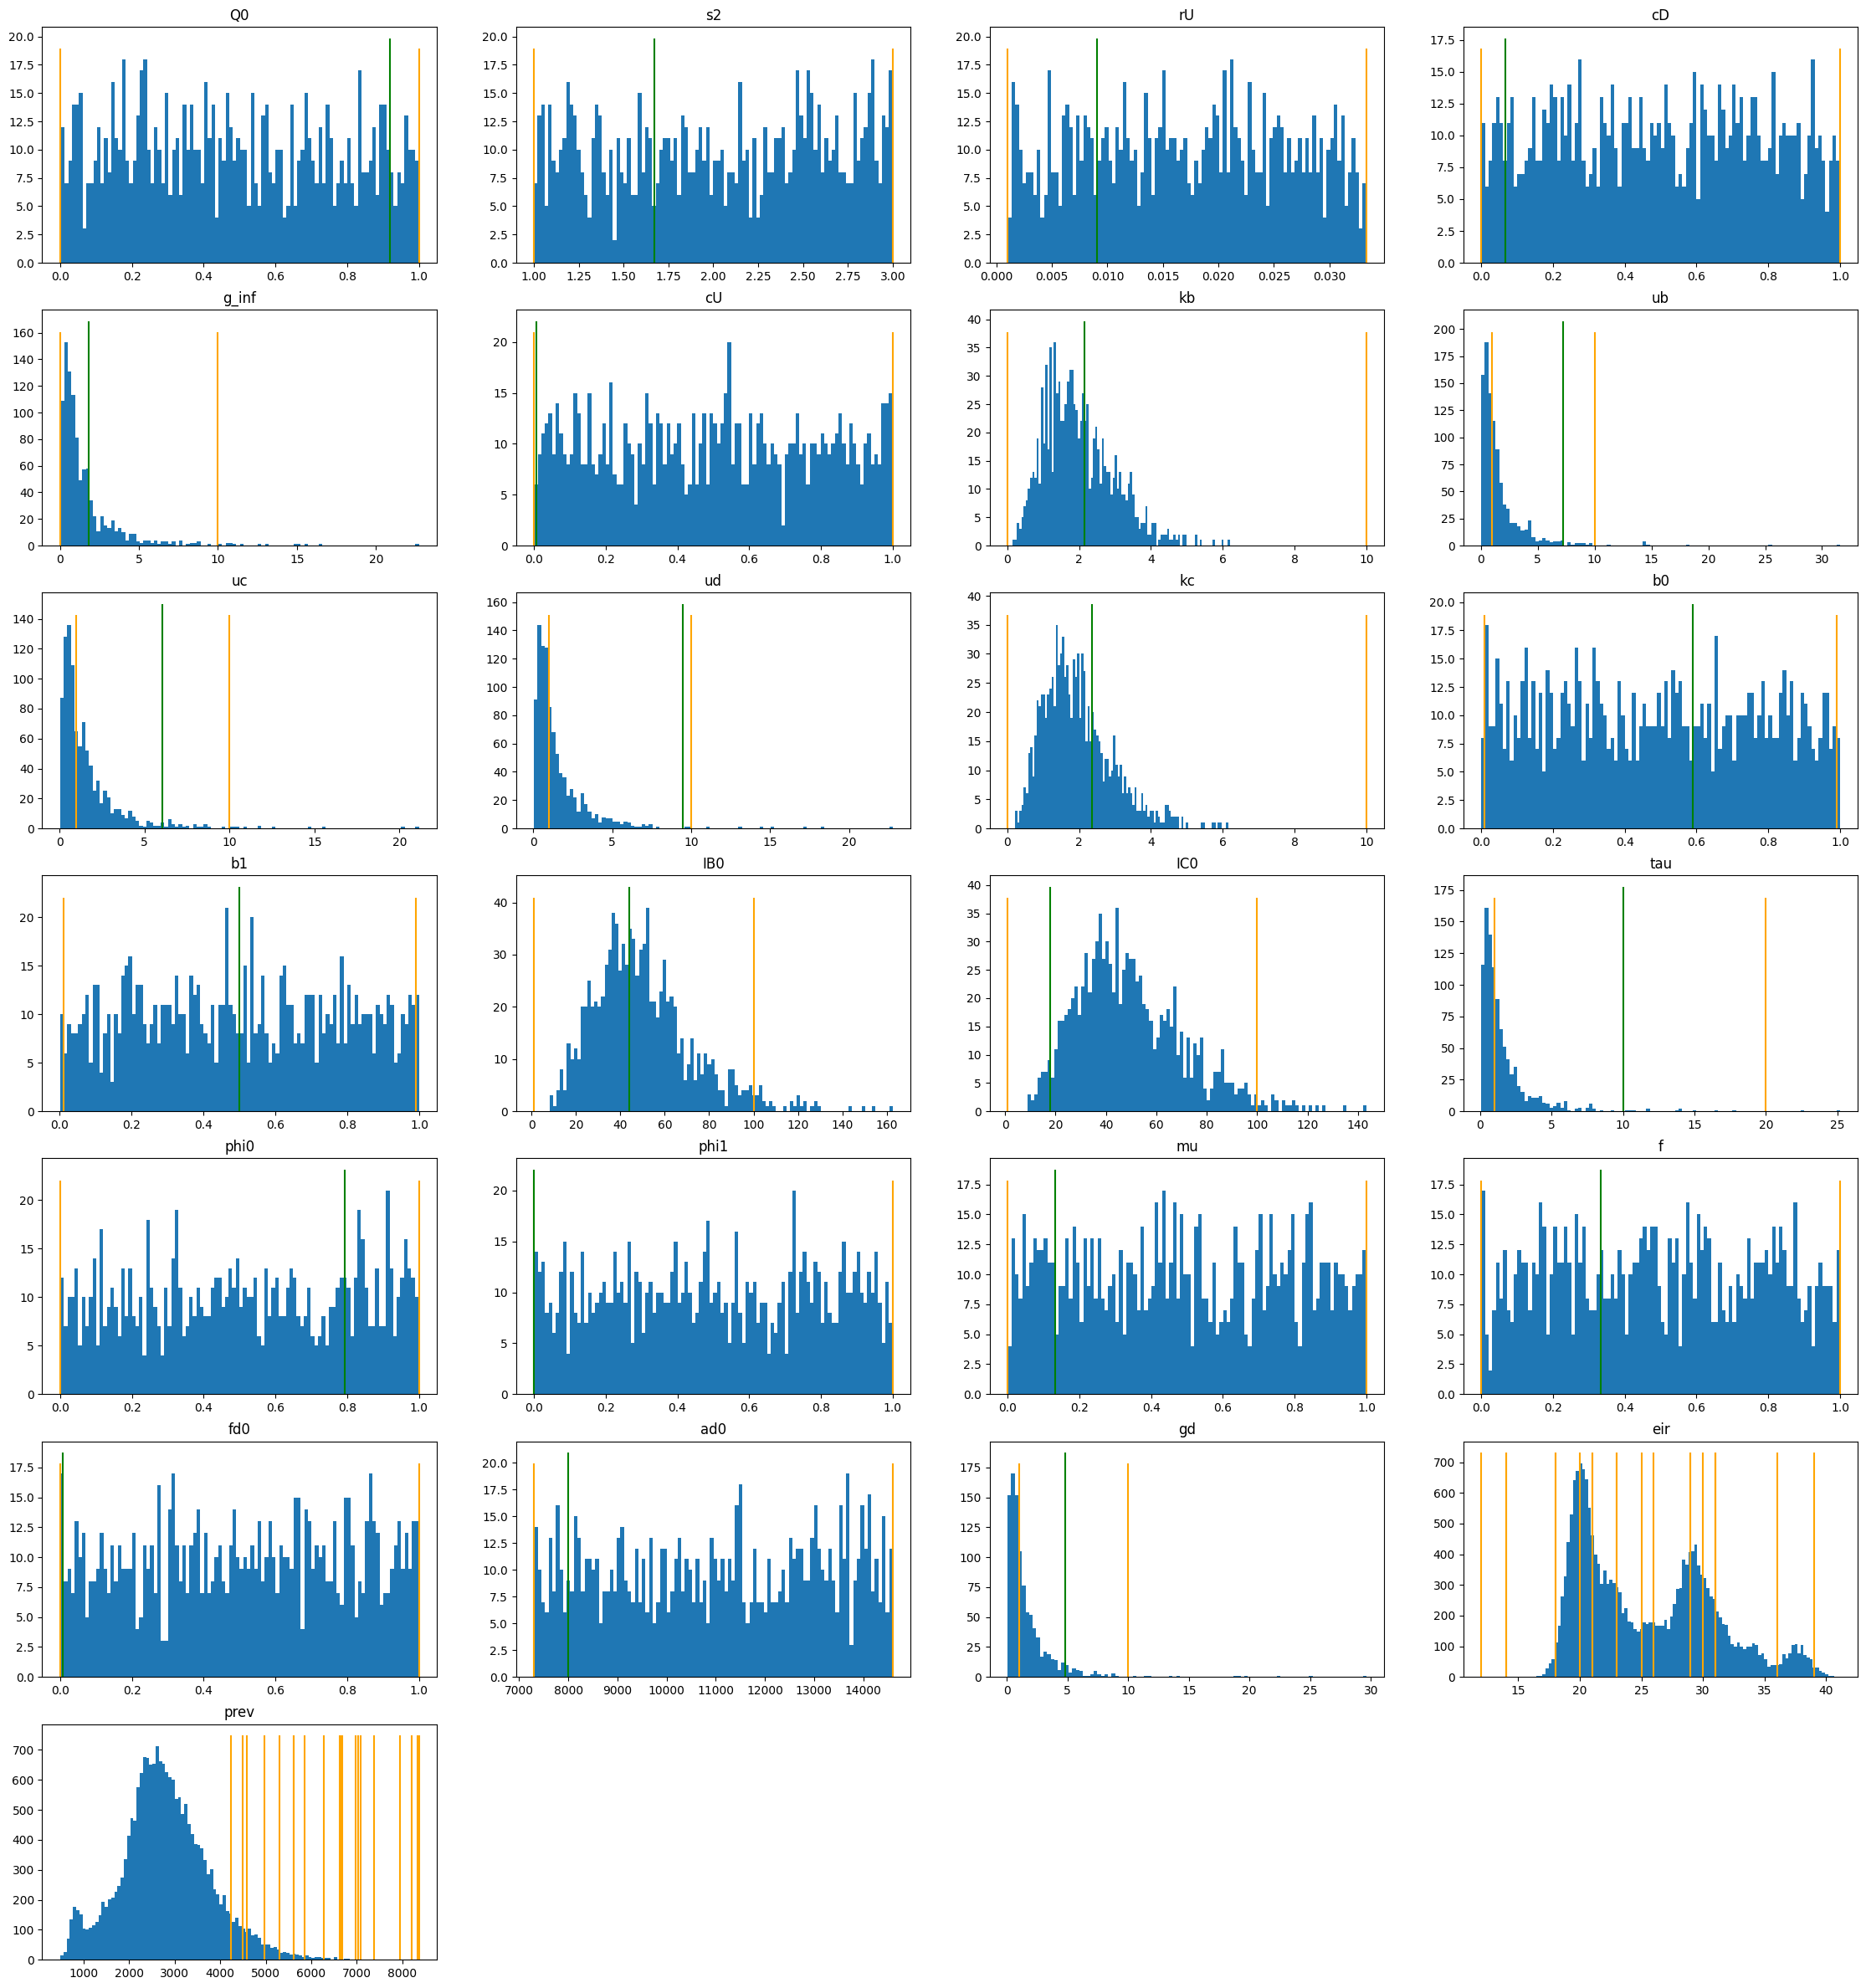

In [117]:
cols = 4
rows = (len(prior) // cols + 1)
prior_keys = list(prior.keys())
bounds_dict = { n: (l, u) for n, l, u in bounds.itertuples(index=False) }
default_dict = dict(default_params.itertuples(index=False))
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows, 30))
for c in range(cols):
    for r in range(rows):
        if cols * r + c < len(prior_keys):
            ax = axes[r][c]
            k = prior_keys[cols * r + c]
            ax.hist(prior[k].numpy().flatten(), bins=100)
            if k in bounds_dict.keys():
                ax.vlines(bounds_dict[k], 0, ax.get_ylim()[1], color='orange')
            if k in default_dict.keys():
                ax.vlines(default_dict[k], 0, ax.get_ylim()[1], color='green')
            elif k == 'eir':
                ax.vlines(EIR_sample, 0, ax.get_ylim()[1], color='orange')
            elif k == 'prev':
                ax.vlines(prev_sample * pop_sample, 0, ax.get_ylim()[1], color='orange')
            ax.set_title(k)
        else:
            fig.delaxes(axes[r][c])

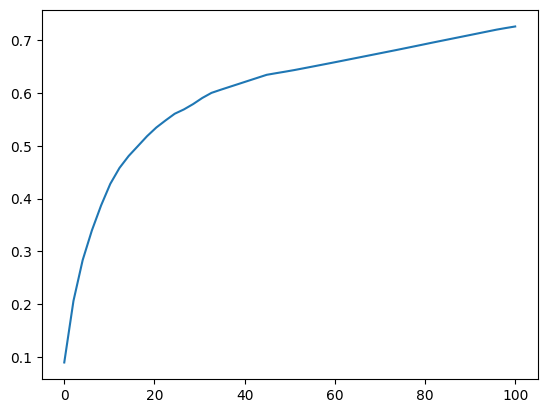

In [80]:
eir_space = np.linspace(0., 100., dtype=np.float32)
eir_prev = model_prev(
    *[
        tf.constant(default_dict[name], dtype=tf.float32)
        for name in [
            's2',
            'rU',
            'cD',
            'cU',
            'g_inf',
            'ud',
            'ad0',
            'fd0',
            'gd',
            'b0',
            'b1',
            'IB0',
            'kb',
            'ub',
            'phi0',
            'phi1',
            'IC0',
            'kc',
            'uc',
            'tau',
            'mu',
            'f',
            'Q0'
        ]
    ],
    eir_space
)
plt.plot(eir_space, eir_prev[0])

In [118]:
%%time
# Initialize the HMC transition kernel.
tf.config.experimental.enable_tensor_float_32_execution(False)
num_results = 100#int(1e3)
num_burnin_steps = 100#int(1e3)

num_chains = 10

observed_prev = tf.constant(pop_sample * prev_sample)
initial_state_dict = joint_dist.sample(num_chains)
initial_state_dict.pop('prev')
initial_state = list(initial_state_dict.values())

def log_prob(*state):
    return prob_prev(*state).log_prob(observed_prev)
    #return joint_dist.log_prob(
    #    *state,
    #    observed_prev
    #)

mcmc = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob,
        num_leapfrog_steps=3,
        step_size=1.
    ),
    num_adaptation_steps=int(num_burnin_steps * 0.8)
)

def run_chain():
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      parallel_iterations=num_chains,
      kernel=mcmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )

samples, acceptance = run_chain()

CPU times: user 45.4 s, sys: 729 ms, total: 46.2 s
Wall time: 43 s


In [119]:
acceptance.numpy().mean()

0.0

In [120]:
joint_dist.log_prob(*initial_state, observed_prev)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ -89814.05 , -183649.98 ,  -54730.84 , -136915.5  ,  -83203.24 ,
        -41188.453,  -59863.2  ,  -51922.504,  -66962.555,  -58717.742],
      dtype=float32)>

In [121]:
prob_prev(*initial_state).log_prob(observed_prev)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ -89759.266, -183593.4  ,  -54665.78 , -136867.9  ,  -83148.47 ,
        -41133.574,  -59801.246,  -51871.29 ,  -66915.58 ,  -58661.71 ],
      dtype=float32)>

In [122]:
pop_sample_tf * model_prev(*initial_state)

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[2479.4834 , 2357.0684 , 2120.4636 , 1928.4069 , 2012.1941 ,
        2154.7688 , 2311.678  , 1806.8309 , 1863.0421 , 2291.2366 ,
        2117.048  , 2035.0275 , 2263.8186 , 1977.3025 , 2252.2095 ,
        1963.6597 , 2252.3804 , 2175.1167 , 1995.6876 , 2283.5818 ],
       [1097.3262 , 1057.0198 ,  924.8962 ,  854.66876,  872.3414 ,
         951.3303 , 1040.3843 ,  770.6083 ,  828.19366, 1027.6521 ,
         922.3578 ,  930.2649 ,  969.27783,  856.15607, 1045.7045 ,
         877.6729 , 1011.0062 ,  983.4485 ,  899.6433 , 1013.3936 ],
       [3467.0093 , 3329.7852 , 2927.726  , 2746.6108 , 2813.1326 ,
        3048.367  , 3208.3574 , 2458.24   , 2608.9946 , 3270.076  ,
        3001.696  , 2931.3386 , 3168.2603 , 2810.2793 , 3185.1511 ,
        2760.0454 , 3115.2566 , 3049.6736 , 2767.6428 , 3239.053  ],
       [1667.6151 , 1572.3788 , 1400.4261 , 1232.592  , 1290.4564 ,
        1404.8306 , 1548.6152 , 1140.6721 , 1217.9535 , 1486.07

In [123]:
observed_prev

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([8367.213 , 7380.4473, 5611.829 , 4977.0225, 6272.166 , 8339.475 ,
       7092.579 , 4585.1074, 6626.396 , 4232.1846, 5609.6963, 5848.7837,
       6657.4844, 4494.3257, 6673.853 , 5303.9707, 6982.93  , 7954.1045,
       7034.824 , 8200.774 ], dtype=float32)>

In [124]:
posterior = dict(zip(initial_state_dict.keys(), samples))

<Figure size 640x480 with 0 Axes>

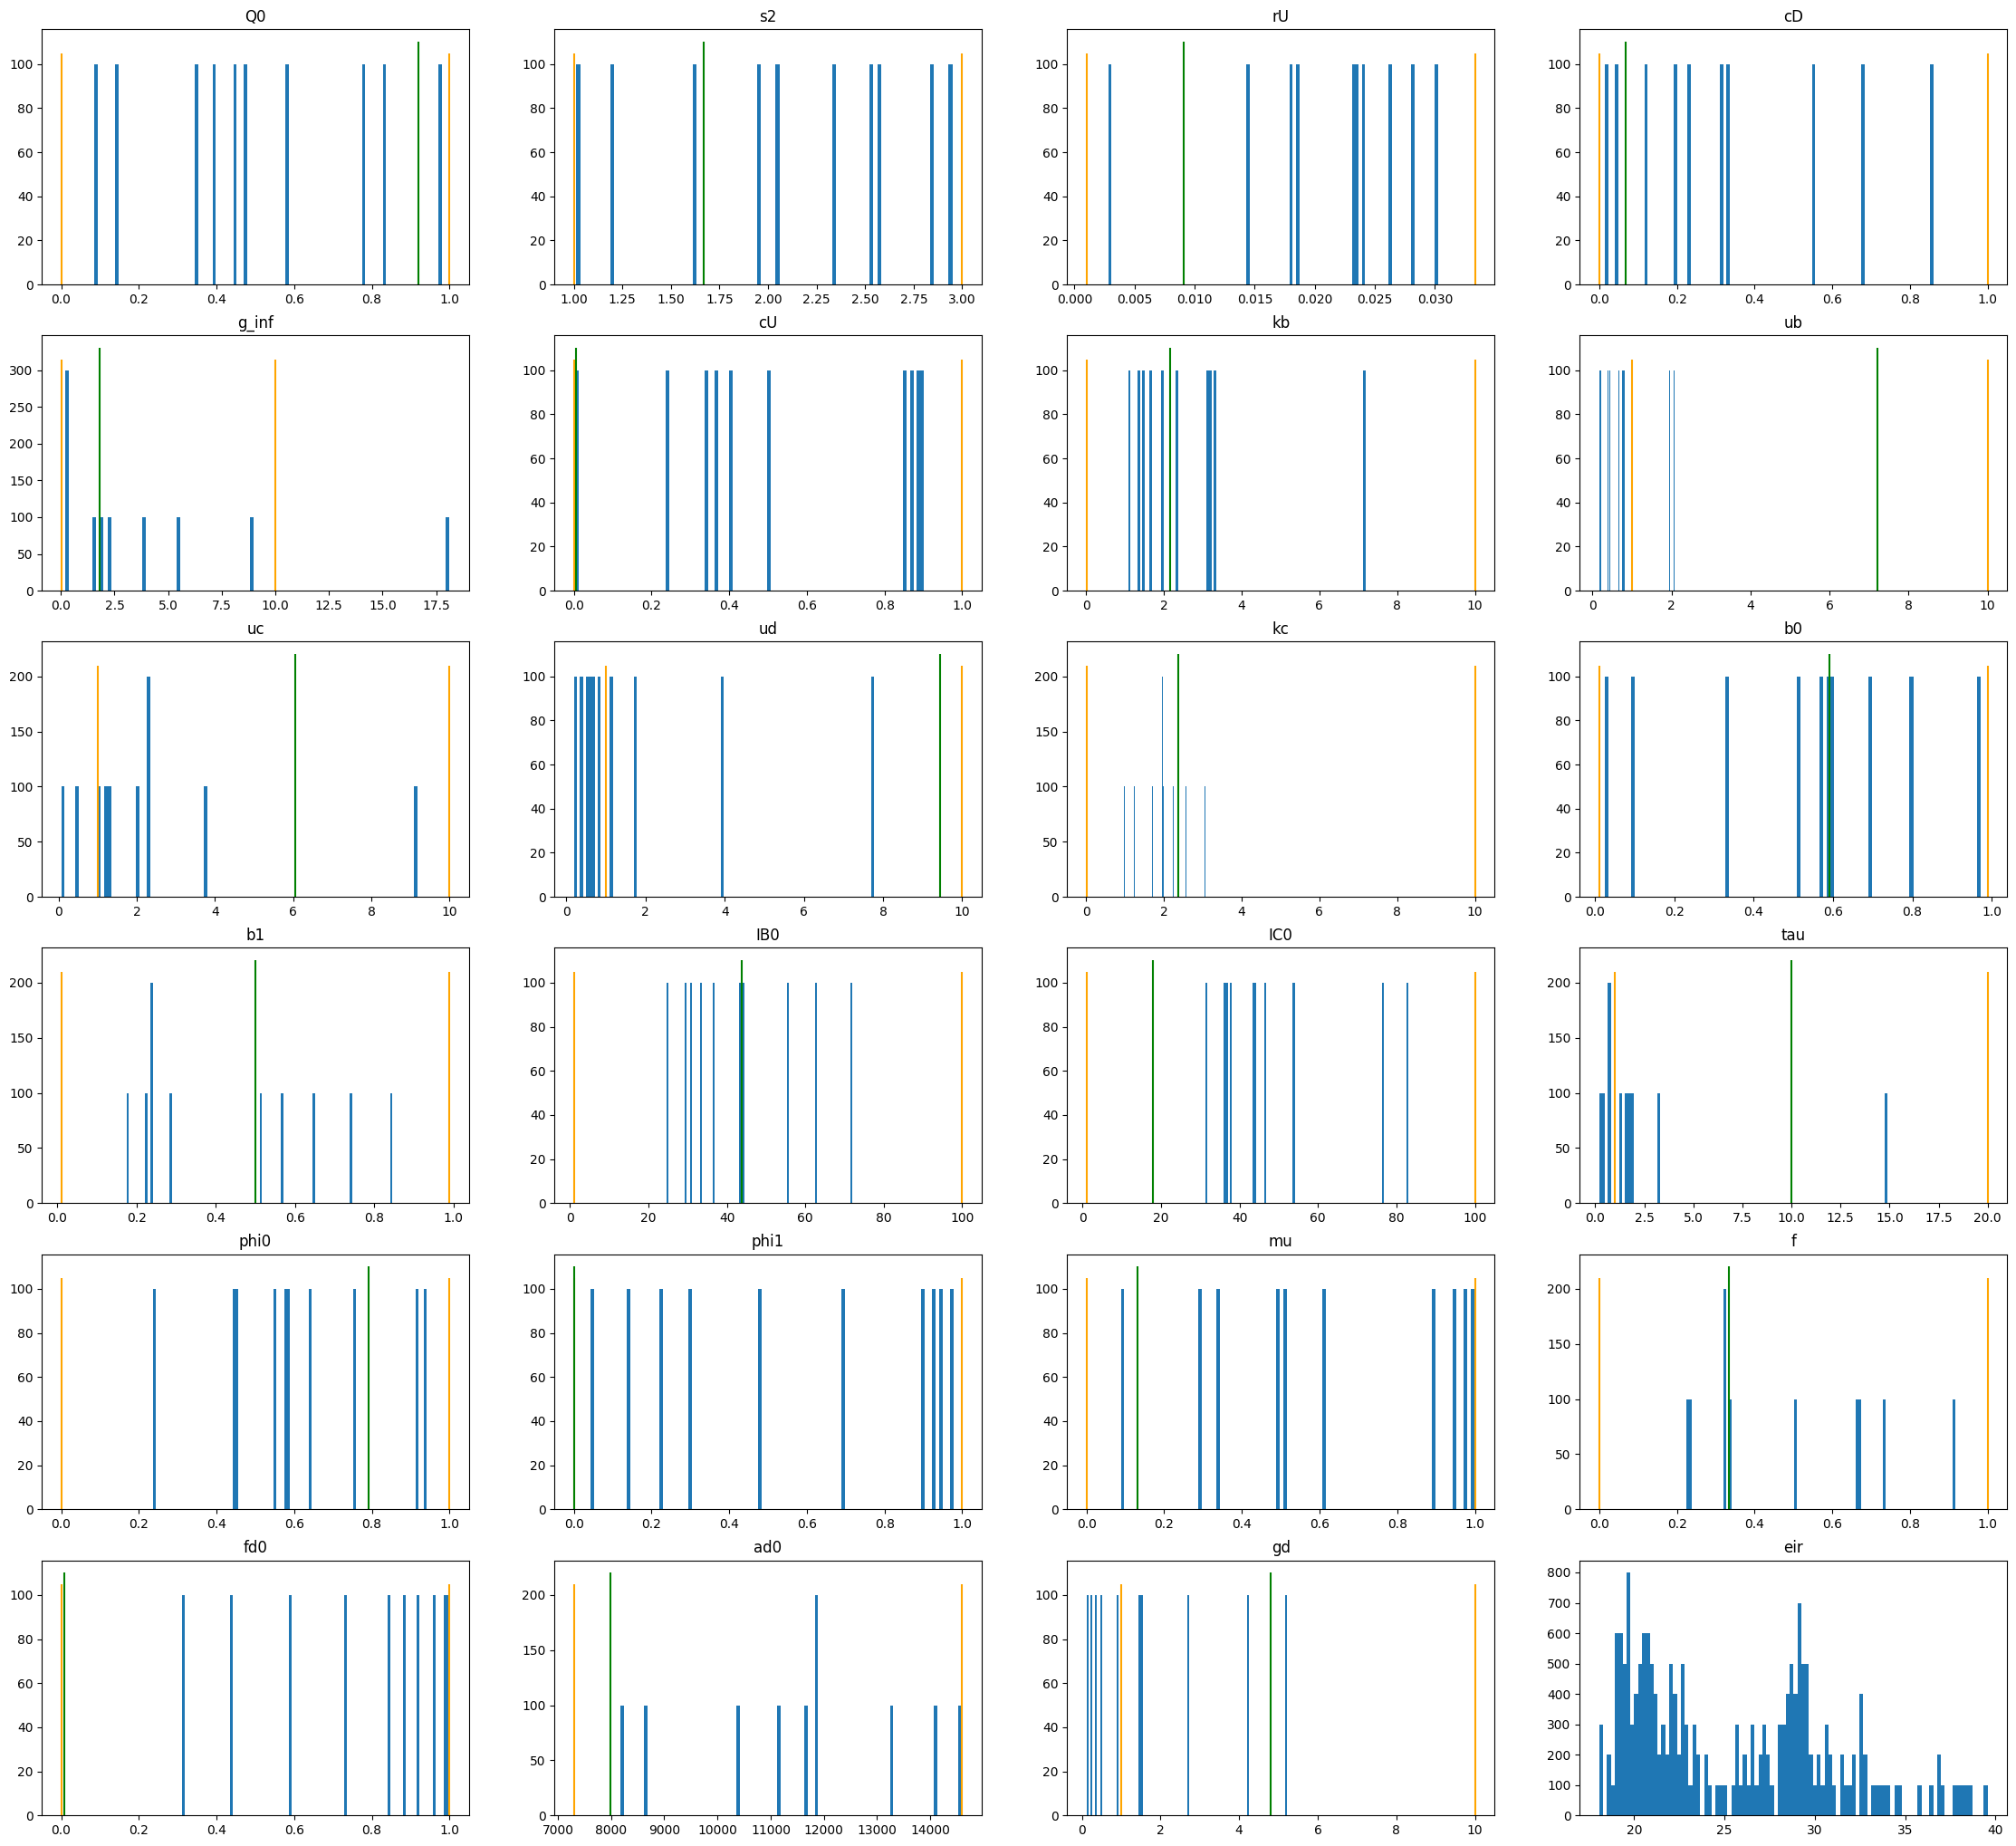

In [125]:
cols = 4
rows = (len(posterior) // cols + 1)
posterior_keys = list(posterior.keys())
bounds_dict = { n: (l, u) for n, l, u in bounds.itertuples(index=False) }
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows, 30))
for c in range(cols):
    for r in range(rows):
        if cols * r + c < len(posterior_keys):
            ax = axes[r][c]
            k = posterior_keys[cols * r + c]
            ax.hist(posterior[k].numpy().flatten(), bins=100)
            if k in bounds_dict.keys():
                ax.vlines(bounds_dict[k], 0, ax.get_ylim()[1], color='orange')
            elif k == 'prev':
                ax.vlines(np.average(prev_sample * pop_sample), 0, ax.get_ylim()[1], color='orange')
            if k in default_dict.keys():
                ax.vlines(default_dict[k], 0, ax.get_ylim()[1], color='green')
            ax.set_title(k)
        else:
            fig.delaxes(axes[r][c])

<Figure size 640x480 with 0 Axes>

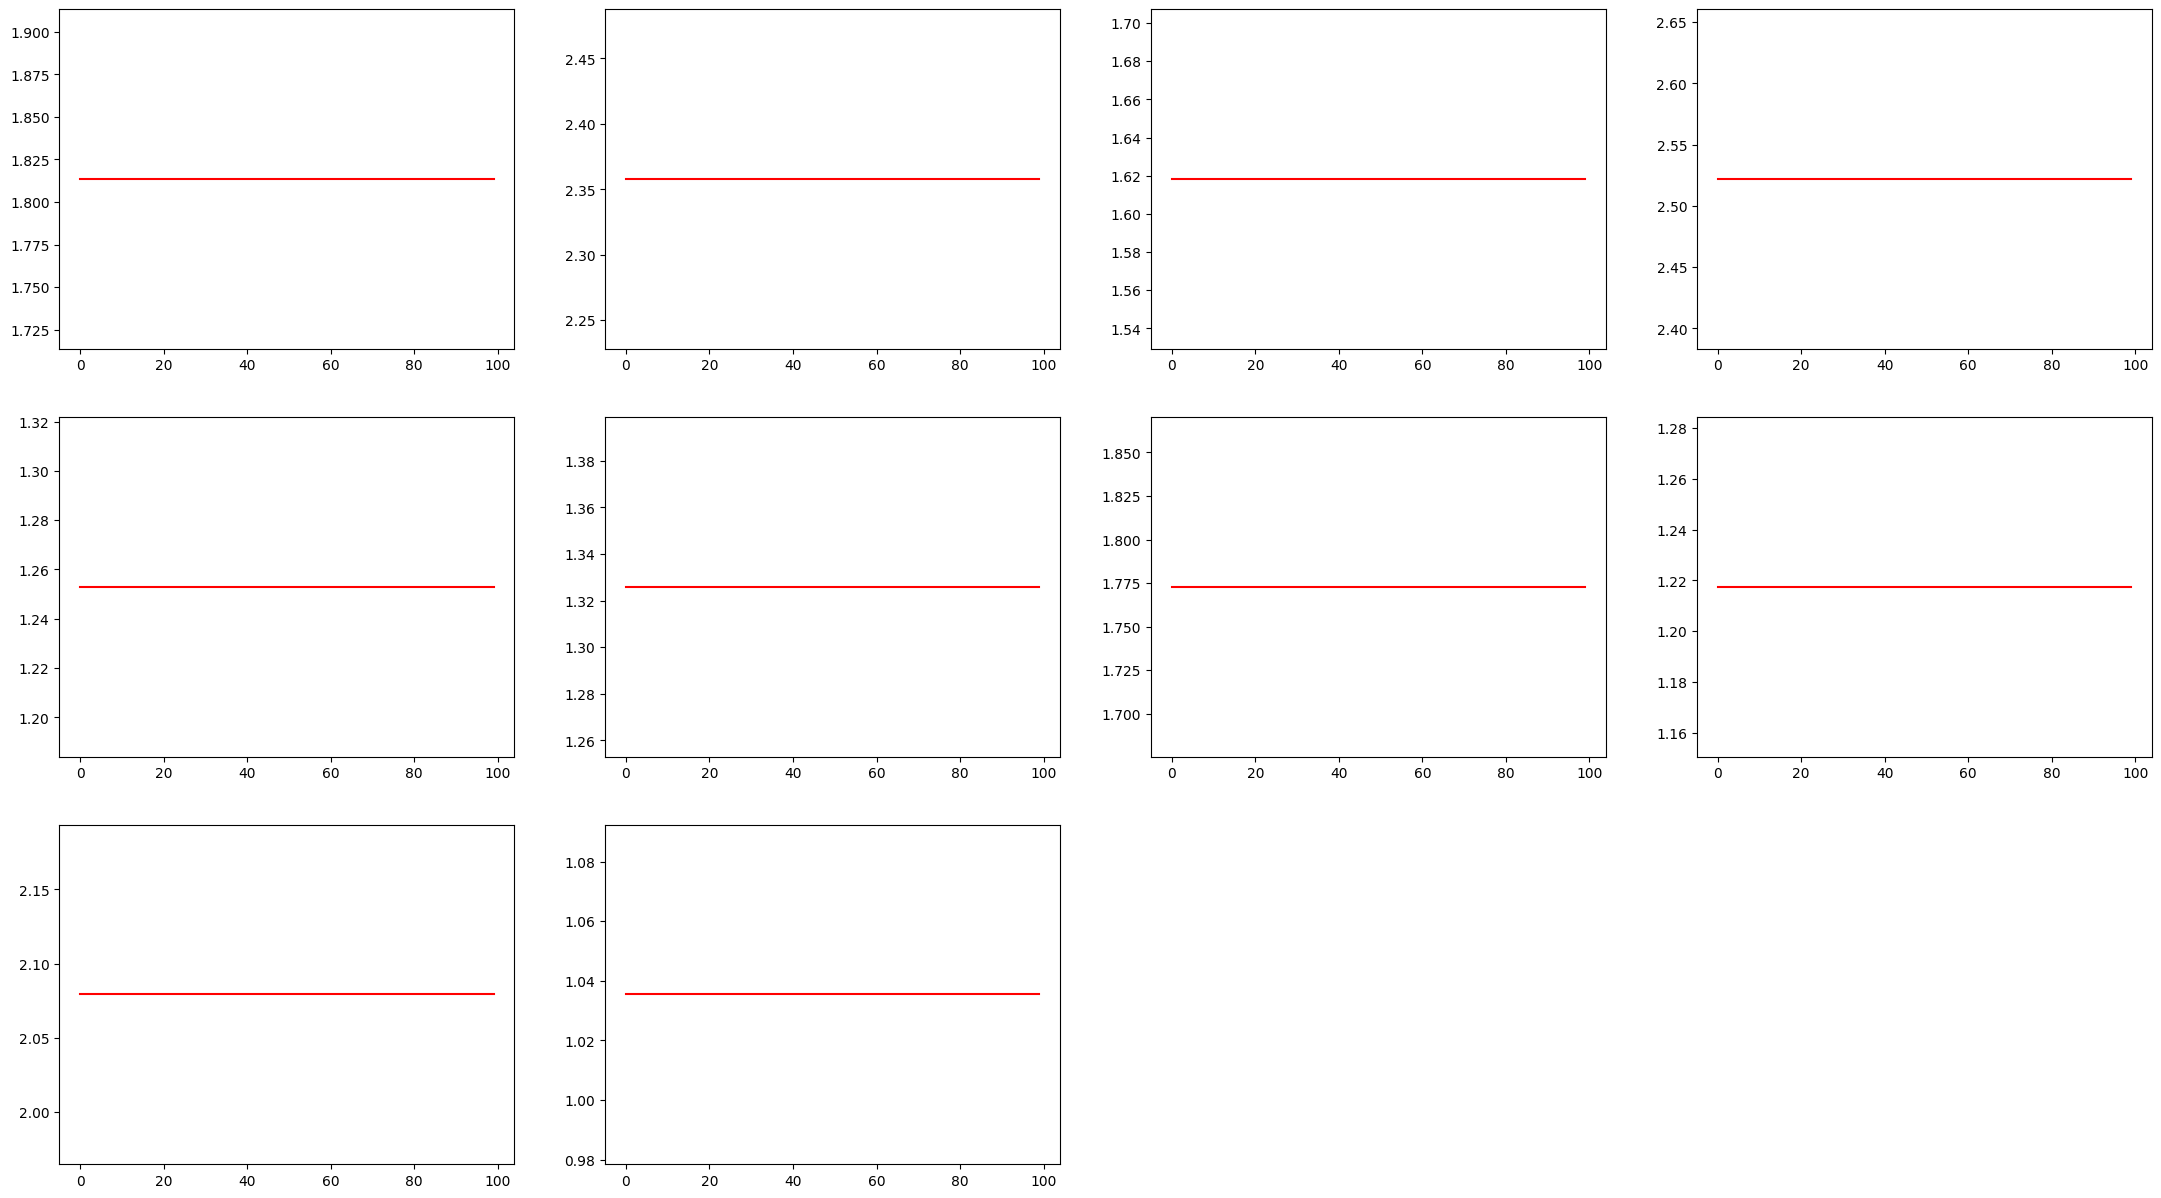

In [22]:
variable = 0
cols = 4
rows = (num_chains // cols + 1)
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows + 15, 15))
for c in range(cols):
    for r in range(rows):
        if len(axes.shape) == 1:
            ax = axes[c]
        else:
            ax = axes[r][c]
        i = cols * r + c
        if i < num_chains:
            ax.plot(samples[variable][:, i:i + 1], color='red')
        else:
            fig.delaxes(ax)

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [20.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([6.53170227e+09, 4.39653695e+11, 8.72775680e+11, 1.30589760e+12,
        1.73901965e+12, 2.17214157e+12, 2.60526362e+12, 3.03838554e+12,
        3.47150746e+12, 3.90462964e+12, 4.33775156e+12, 4.77087348e+12,
        5.20399566e+12, 5.63711731e+12, 6.07023949e+12, 6.50336115e+12,
        6.93648333e+12, 7.36960551e+12, 7.80272717e+12, 8.23584935e+12,
        8.66897153e+12, 9.10209371e+12, 9.53521537e+12, 9.96833703e+12,
        1.04014597e+13, 1.08345814e+13, 1.12677030e+13, 1.17008247e+13,
        1.21339474e+13, 1.25670691e+13, 1.30001907e+13, 1.34333134e+13,
        1.38664351e+13, 1.42995567e+13, 1.47326794e+13, 1.51658011e+13,
        1.55989228e+13, 1.60320455e+13, 1.64651671e+13, 1.68982888e

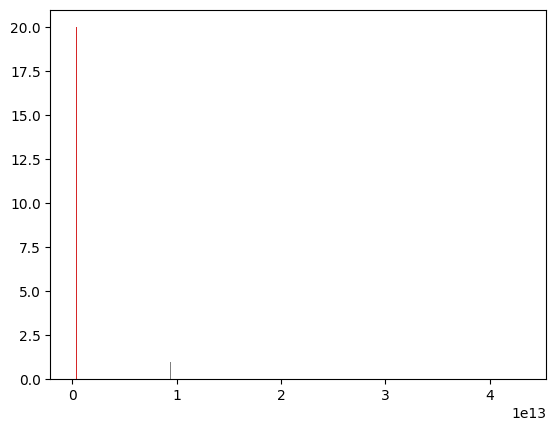

In [126]:
plt.hist(tfp.mcmc.potential_scale_reduction(samples), bins=100)

In [127]:
tfp.mcmc.potential_scale_reduction(samples)

[<tf.Tensor: shape=(), dtype=float32, numpy=5960488000000.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2494122400000.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2410979500000.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8533964000000.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8752762000000.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2791555000000.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=19661744000000.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5964874000000.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7086425000000.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8054924400000.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1817087600000.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3803827000000.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4398380000000.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2029977100000.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4194322600000.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=43318730000000.0>,
 <tf.T